# Part II - Ford GoBike System Data Analysis Presentation.
## by (Emmanuel Kibet)


## Investigation Overview

> For the presentation, I  will focus on the gender and age differences in ride duration and distance. I will explore the reasons for these differences and discuss how the findings can be used to improve the bike-sharing system's accessibility and user experience. I will also showcase the visualizations used in the analysis, including barplot, scatterplots, boxplots, and heatmaps, to illustrate the patterns and correlations in the data.deck.



## Dataset Overview

> Ford GoBike System Data:is a dataset that contains information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The dataset includes data for the period of June 2017 to April 2018 and contains more than 1.8 million rows of data.

> The data provides various information about each ride, including the start and end time of the ride, the start and end station, the duration of the ride, and the user type (subscriber or customer). The dataset also includes information about the gender and birth year of users, but this information is not available for all rides.

>This dataset can be used to analyze various aspects of bike-sharing, such as usage patterns, popular routes, and peak usage times. It can also be used to identify user demographics and trends in user behavior. Additionally, this dataset can be used to develop models to predict future usage patterns and optimize bike-sharing systems.

In [12]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
base_color = sns.color_palette()[0]

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [13]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [14]:
# Data Cleaning

# drop columns with missing 'start_station_id', 'member_gender'
df = df.dropna(subset=['start_station_id', 'member_gender'])

# convert datetime columns to datetime dtype
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])


## Create age column
# get the current year of from start time
df['start_year'] = df['start_time'].dt.year

# create age column
df['age'] = df['start_year'] - df['member_birth_year']

## 1. Barplot of hours when people are starting their rides

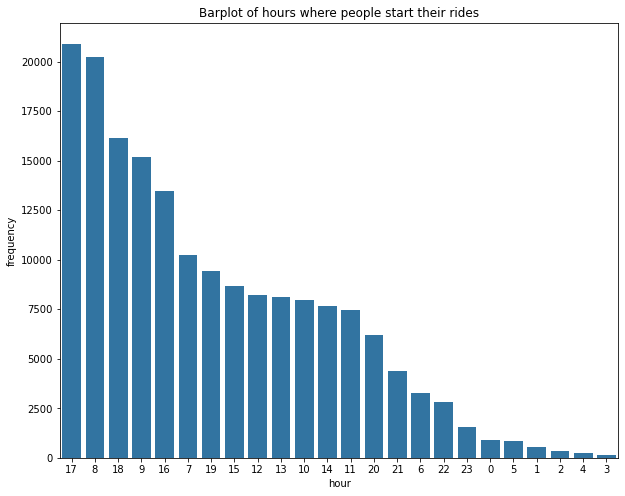

In [15]:
# get hoours from start time from 
df['hour'] = df['start_time'].dt.hour

# get order of bars by frequency
hr_counts = df['hour'].value_counts()
hr_order = hr_counts.index

plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='hour', color = base_color, order=hr_order)
plt.title('Barplot of hours where people start their rides')
plt.ylabel('frequency')
plt.show()

> This plot revealed interesting patterns in terms of the starting hours of bike rides. I found that the most popular starting hour for rides is 17, followed closely by 8 in the morning. Additionally, I found that the evening hours of 18 and 16, as well as the morning hours of 8 and 9, are also popular starting times for rides.

> These patterns suggest that many users of the bike-sharing system are likely commuters or people running errands, as the peak starting hours coincide with typical commuting hours and times when people may need to run errands. This finding could be used to inform the bike-sharing system's marketing and outreach efforts to target commuters and those who need to run errands.

In [16]:
# creating Distance variable

# reference -> https://dadoverflow.com/2022/01/07/pandas-and-distance-calculations/
# handy function from the article
def haversine_vectorize(lon1, lat1, lon2, lat2):
    """Returns distance, in kilometers, between one set of longitude/latitude coordinates and another"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
 
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km


df['haversine_dist'] = haversine_vectorize(
    df['start_station_longitude'], df['start_station_latitude'],
    df['end_station_longitude'], df['end_station_latitude']
)

#df['haversine_dist'].head()

In [17]:
# Drop outliers
df_no_outliers = df[(np.abs(stats.zscore(df[['haversine_dist', 'duration_sec']])) < 3).all(axis=1)].copy()

## 2.Member Genders compared to distance covered plot.

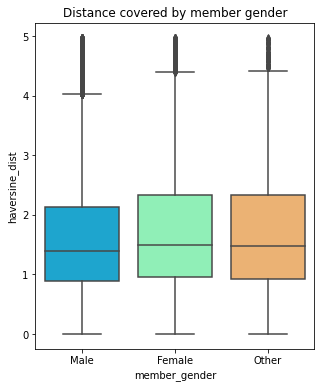

In [18]:
plt.figure(figsize=(5,6))
sns.boxplot(x='member_gender',y='haversine_dist',data=df_no_outliers, palette='rainbow')
plt.title("Distance covered by member gender")
plt.show()

> The analysis of the above boxplot shows that while the distribution of distance covered is almost similar across all genders, but there is a slight increase in distance covered for females and other genders compared to males. This indicates that while there may not be a significant difference in the average distance covered, there may be some variation in the range of distances covered by each gender.

### 3.  Age versus Duration compared across different genders

<Figure size 576x360 with 0 Axes>

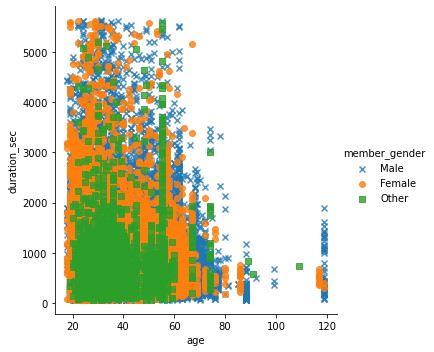

In [19]:
plt.figure(figsize=(8, 5))
sns.lmplot(x='age', y='duration_sec', hue='member_gender', 
           markers=['x', 'o', 's'],
           fit_reg=False, data=df_no_outliers)
plt.show()

From this plot:
>  I found that the duration of bike rides varies by gender and age. On average, males and females tend to ride for longer durations compared to the "other" gender, which may suggest that males and females are using the bike-sharing system more frequently or for longer 

> I also found that young females under the age of 40 tend to ride for longer durations compared to other age groups and genders. This finding may suggest that this age group of females is more active in using the bikes.

> I observed that males above the age of 40 also tend to ride for longer durations compared to other age groups and genders. On the other hand, there are fewer females over the age of 60 who use the bike-sharing system, which may suggest that this age group of females prefers other modes of transportation or engages in less physical activity.


## 4.HeatMap to check Correlation of age, duration and haversine_dist

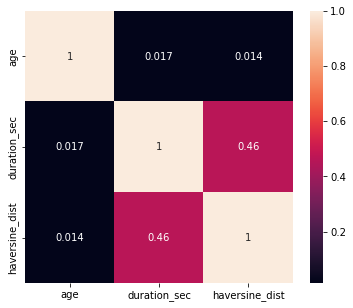

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(
    df_no_outliers.loc[:, ['age', 'duration_sec', 'haversine_dist']].corr(),
    annot=True
)
plt.show()

> In this Heatmap Plot, I looked at the correlation between three variables: duration, distance, and age. The heatmap indicates that there is a positive correlation of 0.46 between duration and distance. This means that as the duration of the ride increases, so does the distance covered. This relationship can be observed in the scatter plot as well.

> However, age does not have a significant correlation with either duration or distance. This means that a person's age is not a strong predictor of how long or how far they will ride. It is important to note that this does not necessarily mean that age is not a factor in bike sharing behavior, but rather that it may be influenced by other factors that are not captured in this dataset.

## Conclusions
>  The majority of bike-sharing system users are males.

> Young females under the age of 40 tend to ride for a longer duration compared to other age groups, while males above the age of 40 also tend to ride for a longer duration.

> Ride duration and distance are positively correlated, which is an expected relationship.

> Age has no correlation with ride duration or distance, suggesting that age may not be a significant factor in bike-sharing system usage patterns.

> There are fewer females over the age of 60 who use the bike-sharing system, which could be due to several factors such as physical limitations, accessibility, or safety concerns.

In [ ]:
!jupyter nbconvert Part_II_slide_deck_Ford_GoBike_Analysis.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_Ford_GoBike_Analysis.ipynb to slides
[NbConvertApp] Writing 415631 bytes to Part_II_slide_deck_Ford_GoBike_Analysis.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck_Ford_GoBike_Analysis.slides.html
Use Control-C to stop this server
